In [0]:
#imports
import tensorflow as tf
import os
import random
import numpy as np
 
from os import listdir
from tqdm import tqdm 

import cv2
from sklearn.model_selection import KFold
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
#mount gdrive
drive_variable = drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#DEFINE CONSTANTS
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
N_SPLIT = 3
PATH = '/content/gdrive/My Drive/IWM/DnoOka/'

In [0]:
#Load file names 
data_files = [f for f in listdir(PATH+'data')]
result_files = [f for f in listdir(PATH+'result')]

In [0]:
#Reading images
data = [cv2.imread(PATH+'data/'+img_name) for img_name in sorted(data_files)]

In [0]:

result = [cv2.imread(PATH+'result/'+img_name)[:,:,1] for img_name in sorted(result_files)]

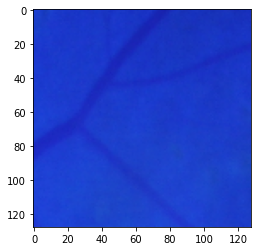

In [0]:
plt.imshow(data[6])

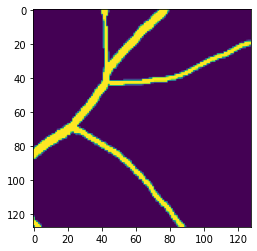

In [0]:
plt.imshow(result[6])

In [0]:
print(len(data),len(result))

7300 7300


In [0]:
#Creating empty numpy arrays
X_train = np.zeros((len(data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(result), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(result), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [0]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['accuracy'])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 128, 128, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_285 (Conv2D)             (None, 128, 128, 16) 448         lambda_15[0][0]                  
__________________________________________________________________________________________________
dropout_135 (Dropout)           (None, 128, 128, 16) 0           conv2d_285[0][0]                 
___________________________________________________________________________________________

In [0]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint(PATH+'model_dno_oka.h5', verbose=1, save_best_only=True)

callbacks = [
        checkpointer,     
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)]
####################################

In [0]:
#################################
#model training
results = []
model.save_weights(PATH+"wagi.hdf")
kfold_counter = 0
for train_index, test_index in KFold(10).split(data):
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(PATH+'model_dno_oka'+(str)(kfold_counter)+'.h5', verbose=1, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
    X_train, X_test = np.array(data)[train_index.astype(int)],np.array(data)[test_index.astype(int)]
    Y_train, Y_test = np.array(result)[train_index.astype(int)],np.array(result)[test_index.astype(int)]
    results.append(model.fit(X_train, Y_train,validation_data=(X_test,Y_test), batch_size=128, epochs=500,callbacks=callbacks))
    model.save_weights(PATH+'model_dno_oka'+(str)(kfold_counter)+'fin.h5')
    model.load_weights(PATH+"wagi.hdf")
    kfold_counter+=1

Epoch 1/500
52/52 [==============================] - ETA: 0s - loss: 2.1888 - accuracy: 0.2427
Epoch 00001: val_loss improved from inf to 2.05900, saving model to /content/gdrive/My Drive/IWM/DnoOka/model_dno_oka0.h5
52/52 [==============================] - 9s 181ms/step - loss: 2.1888 - accuracy: 0.2427 - val_loss: 2.0590 - val_accuracy: 0.2795
Epoch 2/500
52/52 [==============================] - ETA: 0s - loss: 2.1176 - accuracy: 0.5106
Epoch 00002: val_loss improved from 2.05900 to 1.96699, saving model to /content/gdrive/My Drive/IWM/DnoOka/model_dno_oka0.h5
52/52 [==============================] - 8s 162ms/step - loss: 2.1176 - accuracy: 0.5106 - val_loss: 1.9670 - val_accuracy: 0.5716
Epoch 3/500
52/52 [==============================] - ETA: 0s - loss: 2.0093 - accuracy: 0.7518
Epoch 00003: val_loss improved from 1.96699 to 1.90226, saving model to /content/gdrive/My Drive/IWM/DnoOka/model_dno_oka0.h5
52/52 [==============================] - 9s 168ms/step - loss: 2.0093 - accurac

23/23 [==============================] - 0s 14ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


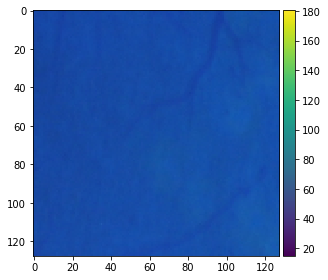

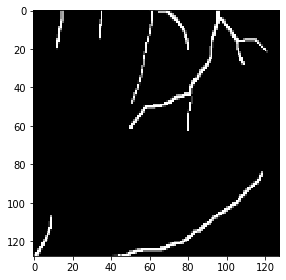

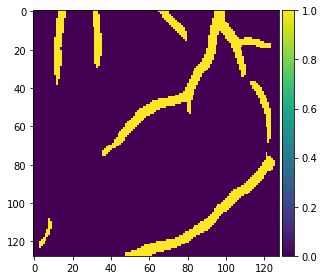

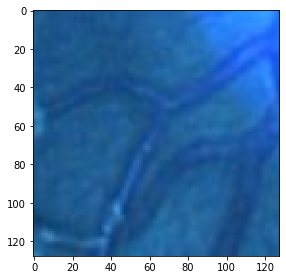

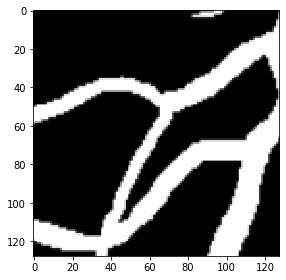

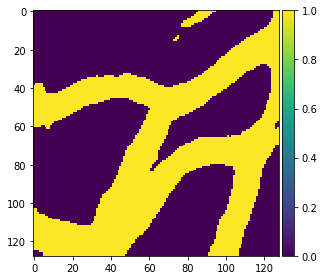

In [0]:
model.load_weights(PATH+"model_dno_oka6fin.h5")

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


"""preds_train_t = preds_train
preds_val_t = preds_val
preds_test_t = preds_test"""

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()